# Discovery of interesting objects in large spectra survey using active deep learning

## Introduction

TODO complete introduction

This letter is organized as follows. Section Data desribes the LAMOST and Ondřejov 2m Perek telescope data sources. Next, section Preprocessing introduces all methods employed to prepare data for learning. Main section is Method section, where our active convolutional neural network is detailed. Finally, in Result section the outcomes of our experiment are discussed.

In [1]:
from active_cnn import data, plot
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
from spectraml import ondrejov


# setup matplotlib: https://matplotlib.org/users/usetex.html
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# seed obtained from https://www.random.org/
# TODO np.random.seed(50)

## Data

Our work is about discovery of interesting objects in LAMOST spectral survey using data from Ondřejov 2m Perek telescope, so this section introduces the to spectrographs and gives information about the spectral data it produced.

### LAMOST spectral survey

In [2]:
# read LAMOST DR2 dataset
lamost_data = data.get_lamost_dataset('data/lamost-dr2.hdf5')
ids, X = lamost_data
ids.shape

(4136482,)

The LAMOST telescope is delivering one of currently largest collections of spectra.
Its publicly accessible data release 2 (DR2) contains slightly more than 4 milion spectra with a spectral resolving power around 1800 covering the range 3690-9100 Angstroms.
The LAMOST pipeline assigns spectra automatically an estimated spectral class.
However, the classification is mostly based on global shape and integral properties of a spectrum in given band-passes using a set of predefined templates.
The local features, as for example detailed line profile, are ignored.
Therefore, strong narrow emissions may be rejected by the pipeline as spoiled pixels.
The archive FITS files have their spectral axis experessed in logarithm of vacuum wavelength.

### Archive of Ondřejov 2m Perek telescope

A unique source of the spectra with emission-line stars (mostly Be and B[e] hot stars with strong winds and several novae) is the archive of spectra obtained with 700 mm camera in the coude spectrograph of the 2m Perek telescope at Ondřejov observatory a part of the Astronomical Institute of the Czech Academy of Sciences.
This continuously growing archive (hereafter CCD700) contains currently about 17000 spectra, the majority of them (more than 13000) are exposed in spectral range 6250-6700 Angstrom with spectral resolving power about 13000.
The spectra are reduced by standard IRAF procedures including the calibration in air wavelengths and heliocentric correction.

From CCD700 archive there is a dataset (hereafter Ondřejov dataset, https://github.com/podondra/ondrejov-dataset) created by Podsztavek (2017).
The dataset contains 12936 labeled spectra, which are divided into 3 classes according to the profile of H$alpha$ spectral line:

- absorption: 6102 spectra (47.17%),
- emission: 5301 spectra (40.98%) and
- double-peak: 1533 spectra (11.85%).

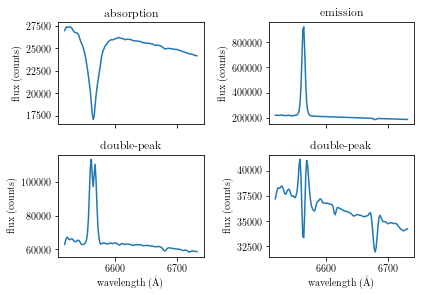

In [3]:
ondrejov_data = data.get_ondrejov_dataset('data/ondrejov-dataset.csv')
ids_train, X_train, labels_train, y_train = ondrejov_data

def preview_profiles():
    fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True)
    labels = ['absorption', 'emission'] + 2 * ['double-peak']
    spectra_id = ['a201403300026', 'lb160035', 'si220021', 'a201306110029']
    for spectrum_id, label, ax in zip(spectra_id, labels, axs.flat):
        ax.set_title(label)
        ax.set_ylabel('flux (counts)')
        plot.plot_ondrejov_spectrum(spectrum_id, ondrejov_data, ax)
    fig.tight_layout()
    axs[1][0].set_xlabel('wavelength (\AA)')
    axs[1][1].set_xlabel('wavelength (\AA)')
    plt.savefig('figures/profiles.pdf')
    plt.show()
    plt.close()

preview_profiles()

## Preprocessing

This section details all the preprocessing methods applied to each spectrum including air to vacuum wavelengths conversion, gaussian blur, resampling and rescaling.

### Domain Adaptation

A common assumption in machine learning is that training data and data, we want our model apply to, are from the same probability distribution $P(X)$. (https://ieeexplore.ieee.org/document/5288526)
But in this work we are interested in the classification of LAMOST archive, desribed by probality distribution $P(Y)$, using training set from Ondřejov spectrograph, distribution $P(X)$, where $P(X) \neq P(Y)$.
In such case we would like to extract as much knowledge as possible from Ondřejov dataset and transfer it to maximally improve our model's performance on LAMOST data.
This is well know problem in machine larning called domain adaptation, which tries to find a function to transform the distribution so that they are very similar. (http://www.icml-2011.org/papers/342_icmlpaper.pdf)

Therefore, to deal with domain adaptation we applied first air to vacuum conversion to Ondřejov data, because spectra from Ondřejov CCD700 archive are in air wavelenght but LAMOST spectra use vacuum wavelenght.
The conversion was made according to formulas provided on http://www.astro.uu.se/valdwiki/Air-to-vacuum%20conversion.

Secondly, because CCD700 spectra have higher spectral resolution, we applied the spectral resolving power degradation, roughly approximated by the convolution with the Gaussian kernel of given pixel width.
Comparison figures of simulated spectra from CCD700 and from LAMOST of all 22 objects mentioned above showed that standard deviation of value 7 pixels works best.

Finnaly, spectra from the LAMOST DR1 were converted from logarithm of vacuum wavelength into linear wavelength.

### Resampling

Convoulutional neural network requires its inputs to be a set of features.
In order to have same features for all spectra they need to be resampled to get measurement in same wavelengths across all spectra.
We choosed to do linear interpolation (using `numpy.interp` function) to 140 uniformly distributed wavelengths in spectral range between 6519 and 6732 Angstroms.

We choosed 140 wavelengths because LAMOST spectra have mostly this number of measurement int the range and the range is derived from the fact that our classification is based on H$alpha$ line and most of Ondřejov spectra are measured between these wavelengths. This range also contains He I 6678 Angstroms line prominent in Be stars.

Then, we created design matrix required for learning, where rows are spectra and columns contain fluxes in specified wavelengths between 6519 and 6732 Angstroms.

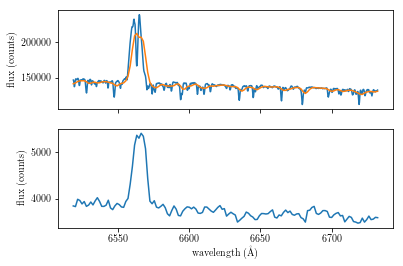

In [4]:
# define wavelengths range
wavelengths = np.linspace(start=6519, stop=6732, num=140)

def preview_domain_adaptation():
    # preview domain adaptation
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

    ondrejov_id = 'a201504150031'
    ondrejov_fits = 'data/' + ondrejov_id + '.fits'
    ondrejov_name, ondrejov_wave, ondrejov_flux = ondrejov.read_spectrum(ondrejov_fits)
    # cut only region of interest
    index = (6519 < ondrejov_wave) & (ondrejov_wave < 6732)
    # plot original spectrum
    ax1.plot(ondrejov_wave[index], ondrejov_flux[index])
    # plot preprocessed spectrum
    plot.plot_ondrejov_spectrum(ondrejov_id, ondrejov_data, ax1)

    lamost_fits = 'spec-55959-GAC_094N27_V3_sp16-125.fits'
    index = lamost_data[0] == lamost_fits
    lamost_flux = lamost_data[1][index].reshape(140)
    ax2.plot(wavelengths, lamost_flux)

    ax1.set_ylabel('flux (counts)')
    ax2.set_ylabel('flux (counts)')
    ax2.set_xlabel('wavelength (\AA)')
    plt.savefig('figures/domain-adaptation.pdf')

preview_domain_adaptation()

### Rescaling

The last step was min-max normalization of spectra's flux into a unit-less range $[-1, 1]$ using equation: 

$$ x' = 2 \frac{x - \min(x)}{\max(x) - \min(x)} - 1.$$

Thus, each spectrum has flux maximum of value 1 and minimum of value -1. We applied this preprocessing procedure for two reasons. Firstly, we would like to classify based on spectra's shape and this procedure effectively suppreses the differences in intensities. Secondly, it gets the value into comfortable small-valued range suitable for machine learning. Note that this in not feature scaling but scaling across each individual spectrum.

So we finally obtained feature vectors with 140 elements for further processing.

In [5]:
X_train.max(), X_train.min(), X.max(), X.min()

(3220351.989224332, -57.8370886671293, 2189252363.450054, -1585763231.4286525)

In [6]:
minmax_scale(X, feature_range=(-1, 1), axis=1, copy=False)
minmax_scale(X_train, feature_range=(-1, 1), axis=1, copy=False)

X_train.max(), X_train.min(), X.max(), X.min()

(1.0000000000000036,
 -1.0000000000000018,
 1.0000000000000284,
 -1.0000000000000142)

## Method

TODO add code reference.

### Convolutional neural network

The machine learning is an iterative process requiring to check various models and their combinations tuned to the particular data characteristics.
One of the most popular methods is the Deep Learning based on Deep convolutional neural networks.

The architecture of convolutional network is inspired primarily by VGGNet, AlexNet and ZFNet.
However, these networks are designed to process multi-layered two-dimensional images while our spectrum can be understood as a single-layered one-dimensional image.
Therefore the architecture needs to be adapted to this difference.
After several experiments we have converged to the architecture which was finally realised using TensorFlow through the Keras high-level interface run on a NVIDIA GTX980 GPU (4 GB memory, 2048 CUDA cores).

In [7]:
#!python3 ondrejov-cnn-test.py

### Active Learning

TODO tady neco vic o active learning, vynechat heuristic

After experimenting with various approaches it became soon obvious, that a somewhat heuristics methodology must be based on interactive visual confirmation of candidates suggested by a neural network.
So far the best working method is based on  principles described in \citet{podsztavek}.

TODO tady doporucuje recenzent novy paragraf, nebude lepsi obrazek, detaily acitve uceni?

The first predictions of emission-line candidates delivered by neural network trained on well exposed CCD700 spectra contained a considerable amount of feature-less noisy spectra.
We needed  thus introduce a new class for the extremely noisy spectra, which was given to the network in the next training stage.
Finally, we iteratively applied several times following loop: 

1. We took all data labelled so far and used SMOTE balancing to obtain the same amount of feature vectors in all classes. Then we trained the neural network on such dataset and predicted labels of unlabelled LAMOST spectra. 
2. From the spectra predicted as single emission or double peak (absorption spectra are not a target class) 100 were randomly selected, visually reviewed and re-classified, if the predicted label was wrong. This corresponds to the passive sampling type of active learning.
3. These target candidates were visually reviewed and re-classified (re-labelled) by the authors (the human decision represents the oracule) in the following way: 

    - If the predicted label was correct, it was confirmed.
    - If the predicted label was wrong, but represented another clearly defined class, it was modified 
    - If the spectrum was confusing, extremely noisy or contained the instrumental or processing artefacts, it was put into noise class. 
    - If the class was difficult to decide the spectrum was not put in training set. This is called in active learning noisy oraculum. Usually it is supposed that the human makes mistakes in labelling and is treated by statics assumptions. We decided to simply ignore this cases for the moment.

All the visually re-labelled spectra were added to the training set (containing thus all Ondřejov spectra and less than 100, those non-classifiable were not put it, new from LAMOST after each iteration).
When the amount of wrongly predicted spectra was very low (only few per 100), we stopped the loop.
The training of the network always finished when there was no improvement of the loss function at least $10^{-5}$ achieved during 50 iterations.

In [13]:
iteration = 1
# hdf5 file for data backup
data_file = 'data/data.hdf5'
# DataFrame for estimate performance
perf = pd.DataFrame(columns=('correct', 'iteration'))
perf.index.name = 'identifier'
# DataFrame for oracle classification
oracle = pd.DataFrame(columns=('label', 'iteration'))
oracle.index.name = 'identifier'

In [14]:
iteration

1

In [15]:
data.save_data(data_file, iteration, X_train, y_train, ids_train, X, ids)

In [ ]:
# train network (run it outside the notebook)
!python3 learning.py $iteration

Using TensorFlow backend.
Epoch 1/1000
2018-10-15 12:50:04.125363: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1356] Found device 0 with properties: 
name: GeForce GTX 980 major: 5 minor: 2 memoryClockRate(GHz): 1.2155
pciBusID: 0000:03:00.0
totalMemory: 3.95GiB freeMemory: 3.87GiB
2018-10-15 12:50:04.125548: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1435] Adding visible gpu devices: 0
2018-10-15 12:50:04.658960: I tensorflow/core/common_runtime/gpu/gpu_device.cc:923] Device interconnect StreamExecutor with strength 1 edge matrix:
2018-10-15 12:50:04.659102: I tensorflow/core/common_runtime/gpu/gpu_device.cc:929]      0 
2018-10-15 12:50:04.659149: I tensorflow/core/common_runtime/gpu/gpu_device.cc:942] 0:   N 
2018-10-15 12:50:04.659484: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1053] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 3603 MB memory) -> physical GPU (device: 0, name: GeForce GTX 980, pci bus id: 0000:03:00.0, compute 

12936/12936 [==============================] - 7s 510us/step - loss: 0.0106
Epoch 82/1000
12936/12936 [==============================] - 7s 513us/step - loss: 0.0142
Epoch 83/1000
12936/12936 [==============================] - 7s 514us/step - loss: 0.0174
Epoch 84/1000
12936/12936 [==============================] - 7s 512us/step - loss: 0.0130
Epoch 85/1000
12936/12936 [==============================] - 7s 511us/step - loss: 0.0129
Epoch 86/1000
12936/12936 [==============================] - 7s 518us/step - loss: 0.0115
Epoch 87/1000
12936/12936 [==============================] - 7s 522us/step - loss: 0.0086
Epoch 88/1000
12936/12936 [==============================] - 7s 514us/step - loss: 0.0097
Epoch 89/1000
12936/12936 [==============================] - 7s 512us/step - loss: 0.0128
Epoch 90/1000
12936/12936 [==============================] - 7s 510us/step - loss: 0.0109
Epoch 91/1000
12936/12936 [==============================] - 7s 518us/step - loss: 0.0138
Epoch 92/1000
12936/1293

12936/12936 [==============================] - 7s 513us/step - loss: 0.0118
Epoch 172/1000
12936/12936 [==============================] - 7s 513us/step - loss: 0.0131
Epoch 173/1000
12936/12936 [==============================] - 7s 517us/step - loss: 0.0080
Epoch 174/1000
12936/12936 [==============================] - 7s 514us/step - loss: 0.0092
Epoch 175/1000
12936/12936 [==============================] - 7s 522us/step - loss: 0.0068
Epoch 176/1000
12936/12936 [==============================] - 7s 512us/step - loss: 0.0077
Epoch 177/1000
12936/12936 [==============================] - 7s 512us/step - loss: 0.0118
Epoch 178/1000
12936/12936 [==============================] - 7s 513us/step - loss: 0.0081
Epoch 179/1000
12936/12936 [==============================] - 7s 513us/step - loss: 0.0111
Epoch 180/1000
12936/12936 [==============================] - 7s 515us/step - loss: 0.0076
Epoch 181/1000
12936/12936 [==============================] - 7s 519us/step - loss: 0.0121
Epoch 182/1000

In [ ]:
f = h5py.File(data_file)
y_pred = f['iteration_{:02}/y_pred'.format(iteration)]
f.close()
labels = y_pred > 0.5
np.unique(labels, return_counts=True)

In [ ]:
emission_index = np.arange(labels.shape[0])[labels]
random_index = np.random.choice(emission_index, size=32, replace=False)
gen = (filename for filename in ids[random_index])

In [ ]:
filename = next(gen)
plot.preview_lamost_spectrum(filename)

In [ ]:
row = pd.Series({'correct': False, 'iteration': iteration}, name=filename)
perf = perf.append(row)

In [ ]:
row = pd.Series({'correct': True, 'iteration': iteration}, name=filename)
perf = perf.append(row)

In [ ]:
# active learning
distance = np.abs(y_pred - 0.5)
index = np.argsort(distance)[:64]
gen = (filename for filename in ids[index])

In [ ]:
filename = next(gen)
plot.preview_lamost_spectrum(filename)

In [ ]:
row = pd.Series({'label': 0, 'iteration': iteration}, name=filename)
oracle = oracle.append(row)

In [ ]:
row = pd.Series({'label': 1, 'iteration': iteration}, name=filename)
oracle = oracle.append(row)

In [ ]:
import importlib
importlib.reload(data)

In [ ]:
X_train, ids_train, y_train, X, ids = data.renew_datasets(
    X_train, ids_train, y_train, X, ids, index, oracle, iteration
)

In [ ]:
iteration += 1

In [ ]:
perf.to_csv('data/perf.csv')
oracle.to_csv('data/oracle.csv')